In [1]:
import talos
import os
import numpy as np
from code.preprocessing import prepare_te_data
from code.models.utils import SequenceGenerator
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
BASE_PATH = 'code/output/hyperoptim/2020-04-19-12-29-19'
PACKAGE_PATH = f'{BASE_PATH}/cnngru.zip'
REPORT_PATH = f'{BASE_PATH}/041920123157.csv'
RANDOM_SEED = 42

In [4]:
DATA_DIR = '../data/'
TE_PATH = os.path.join(DATA_DIR, 'csv', 'te_LMCN.v2.csv')
TE_SAMPLE_NAME = 'CN34_S5_r1_te.h.trim.uncontam'
RNA_PATH = os.path.join(DATA_DIR, 'csv', 'preprocessed.csv')

# Analyze

In [5]:
analyze = talos.Analyze(REPORT_PATH)
analyze.data

round_epochs  val_loss  val_rmse      loss      rmse  ...  optimizer  pool_size  rnn_dim  rnn_dropout      vocab_lengths
0            217  0.000483  0.029736  0.000099  0.007550  ...       adam          2       16          0.0  [5, 66, 23, None]
1            105  0.002054  0.034531  0.001840  0.029599  ...       adam          2       16          0.2  [5, 66, 23, None]
2            210  0.003503  0.037856  0.000831  0.020755  ...       adam          2       16          0.5  [5, 66, 23, None]
3            189  0.000525  0.033947  0.000181  0.010325  ...       adam          2       32          0.0  [5, 66, 23, None]
4            173  0.000877  0.033804  0.000374  0.014742  ...       adam          2       32          0.2  [5, 66, 23, None]
5            292  0.000442  0.030089  0.000324  0.013285  ...       adam          2       32          0.5  [5, 66, 23, None]
6            236  0.001278  0.029957  0.000055  0.005524  ...       adam          2       64          0.0  [5, 66, 23, None]
7            192  0.001001  0.031487  0.000347  0.014160  ...       adam          2       64          0.2  [5, 66, 23, None]
8            156  0.000565  0.030645  0.001002  0.023080  ...       adam          2       64          0.5  [5, 66, 23, None]
9            235  0.000601  0.028237  0.000042  0.004639  ...       adam          2      128          0.0  [5, 66, 23, None]
10           267  0.000727  0.029955  0.000191  0.010540  ...       adam          2      128          0.2  [5, 66, 23, None]
11           219  0.001483  0.032534  0.000337  0.013908  ...       adam          2      128          0.5  [5, 66, 23, None]
12           139  0.003378  0.037573  0.000479  0.016645  ...       adam          2      256          0.0  [5, 66, 23, None]
13           164  0.000573  0.029660  0.000743  0.020388  ...       adam          2      256          0.2  [5, 66, 23, None]
14           332  0.000206  0.031185  0.000332  0.013387  ...       adam          2      256          0.5  [5, 66, 23, None]
15           134  0.004780  0.051707  0.002312  0.030636  ...       adam          2      512          0.0  [5, 66, 23, None]

[16 rows x 20 columns]

In [6]:
analyze.low('val_rmse')

0.028237141668796536

In [7]:
analyze.plot_corr('val_rmse', exclude=[])

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


In [9]:
analyze.plot_bars('rnn_dim', 'val_rmse', 'rnn_dropout', 'lr')

In [10]:
analyze.plot_bars('dense_dim', 'val_rmse', 'dense_dropout', 'lr')

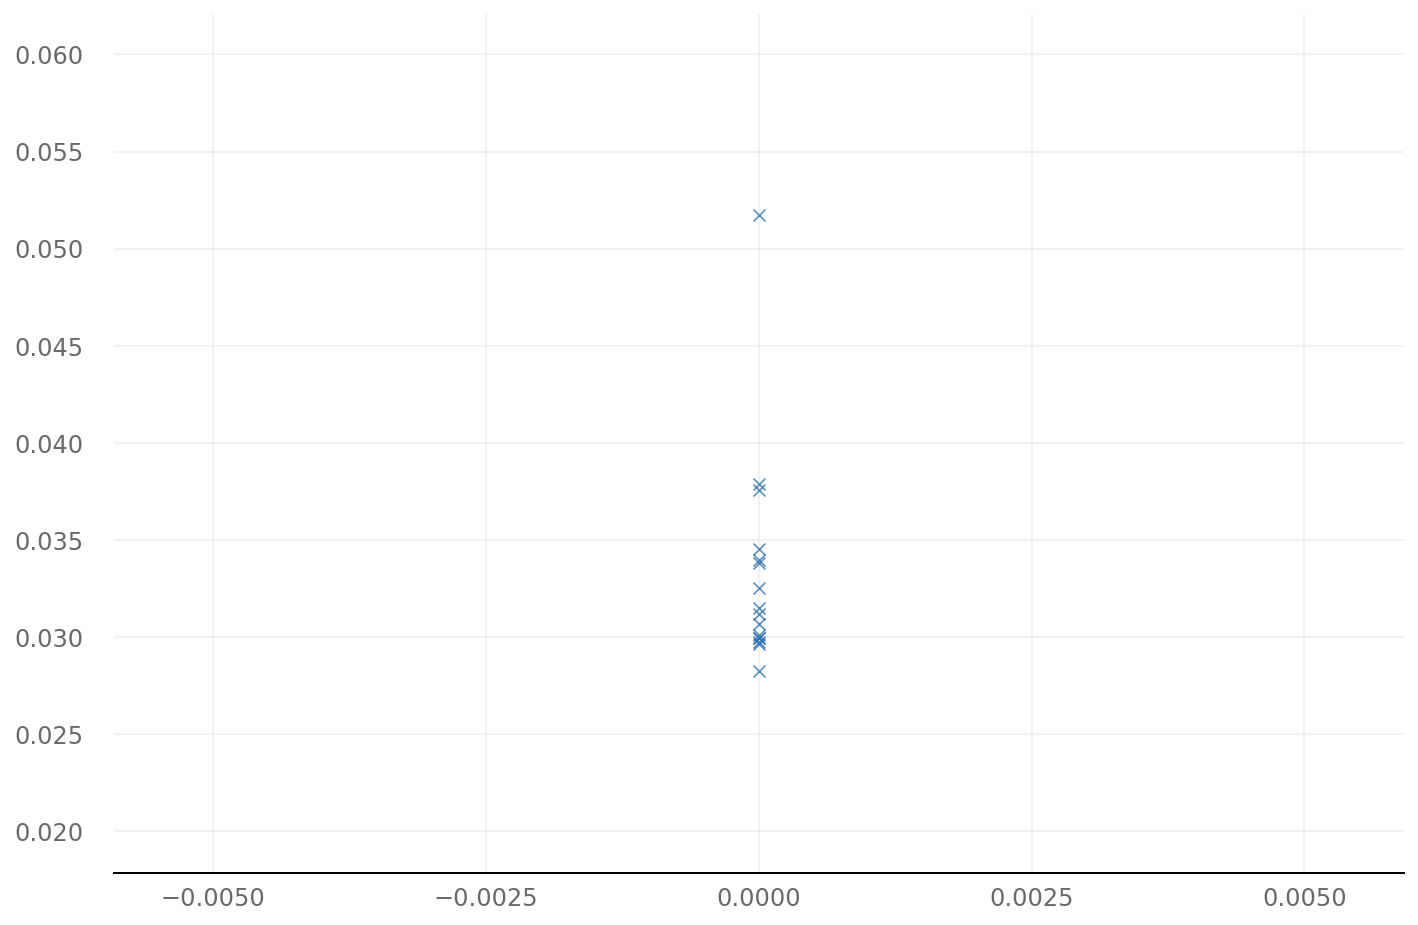

In [11]:
analyze.plot_regs('dense_dropout', 'val_rmse')

# Best Models

In [12]:
experiment = talos.Restore(PACKAGE_PATH)
experiment.details

0                                      1
0                   NaN                                      0
1       experiment_name  output/hyperoptim/2020-04-19-12-29-19
2         random_method                       uniform_mersenne
3      reduction_method                            correlation
4    reduction_interval                                     20
5      reduction_window                                     20
6   reduction_threshold                                    0.2
7      reduction_metric                               val_rmse
8         complete_time                         04/20/20/09:38
9               x_shape                              (7812, 4)
10              y_shape                                (7812,)

In [13]:
experiment.params

{'optimizer': ['adam'],
 'batch_size': [32, 64],
 'epochs': [1000],
 'lr': [0.001],
 'vocab_lengths': [[5, 66, 23, None]],
 'embedding_size': [8, 16, 32, 64],
 'conv_filters': [8, 16, 32, 64, 128, 256],
 'first_conv_size': [5, 7, 9, 15, 21, 24],
 'inner_conv_size': [3, 5, 7, 9],
 'conv_dropout': [0, 0.2, 0.5],
 'pool_size': [2, 3],
 'rnn_dim': [16, 32, 64, 128, 256, 512, 1024],
 'rnn_dropout': [0, 0.2, 0.5],
 'dense_dim': [32, 64, 128, 256, 512, 1024],
 'dense_dropout': [0, 0.2, 0.5]}

In [14]:
x_train, y_train, x_val, y_val, x_test, y_test, word_indices = prepare_te_data(RNA_PATH, TE_PATH, TE_SAMPLE_NAME,
                                                                               max_length=6000, random_seed=RANDOM_SEED)

In [15]:
x_test.shape, y_test.shape

((965, 4), (965,))

In [16]:
def plot_reg(x, y, model):
    y_pred = model.predict_generator(SequenceGenerator(x, y))
    ax = sns.jointplot(np.log1p(y.ravel()), np.log1p(y_pred.ravel()),
                       kind='reg', stat_func=stats.spearmanr, marker='.');
    plt.xlabel('ground truth');
    plt.ylabel('prediction');

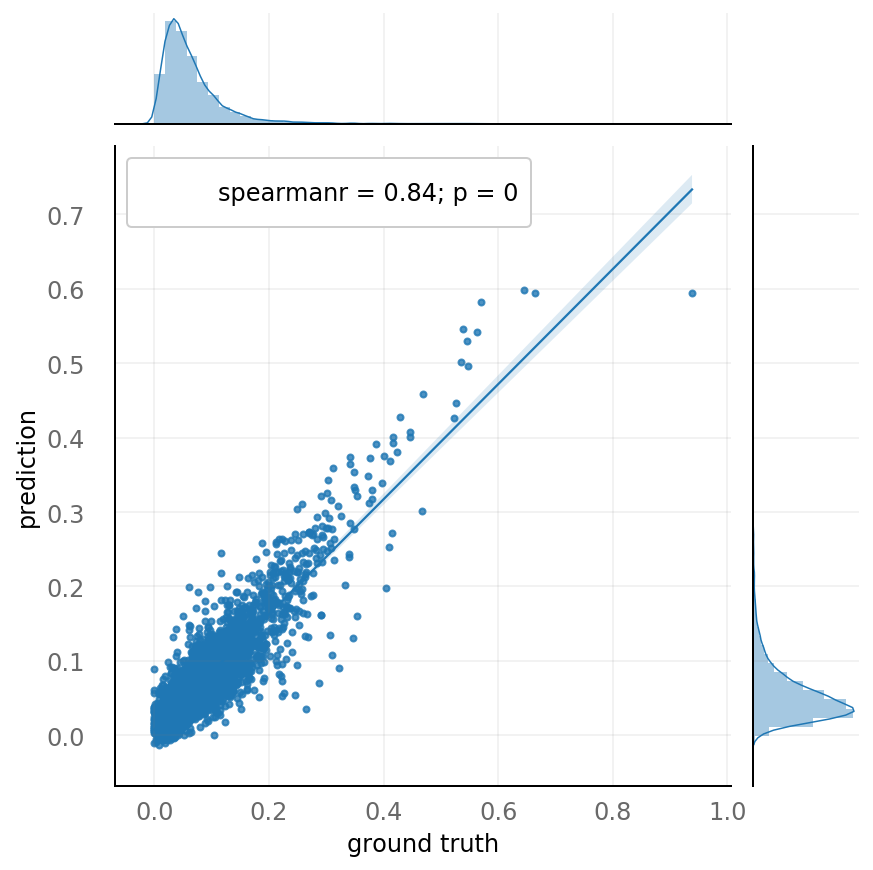

In [17]:
plot_reg(x_train, y_train, experiment.model)

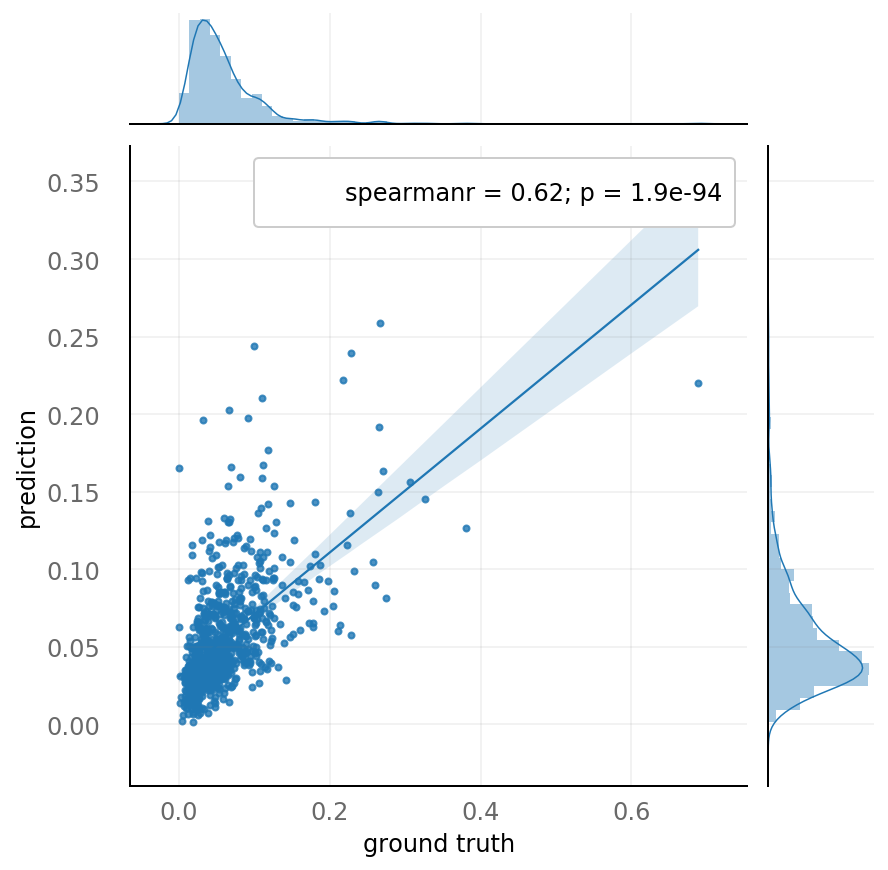

In [18]:
plot_reg(x_val, y_val, experiment.model)

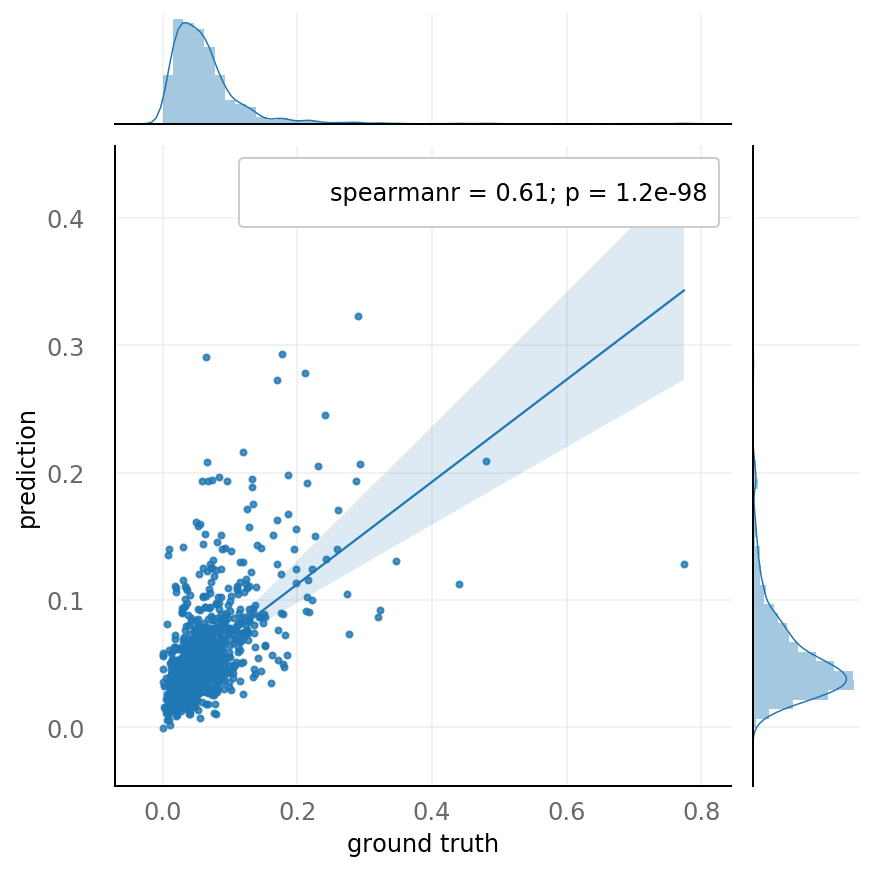

In [19]:
plot_reg(x_test, y_test, experiment.model)